In [11]:
%load_ext autoreload
import ddls

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
node_config = {'type_1':
                  {
                      'num_nodes': 16,
                      'workers_config': 
                          [
                              {
                               'num_workers': 4,
                               'worker': A100
                              }
                          ]
                  }
              }

topology_config = {'type':
                      'torus',
                   'kwargs':
                      {
                          'x_dims': 4,
                          'y_dims': 4
                      }
                  }

jobs_config = {'path_to_files': '/scratch/datasets/ddls/jobs/tensorflow_synthetic_graphs/valid',
               'job_interarrival_time_dist': Uniform(min_val=1, max_val=1000),
               'max_files': 1,
               'job_sampling_mode': 'remove'}

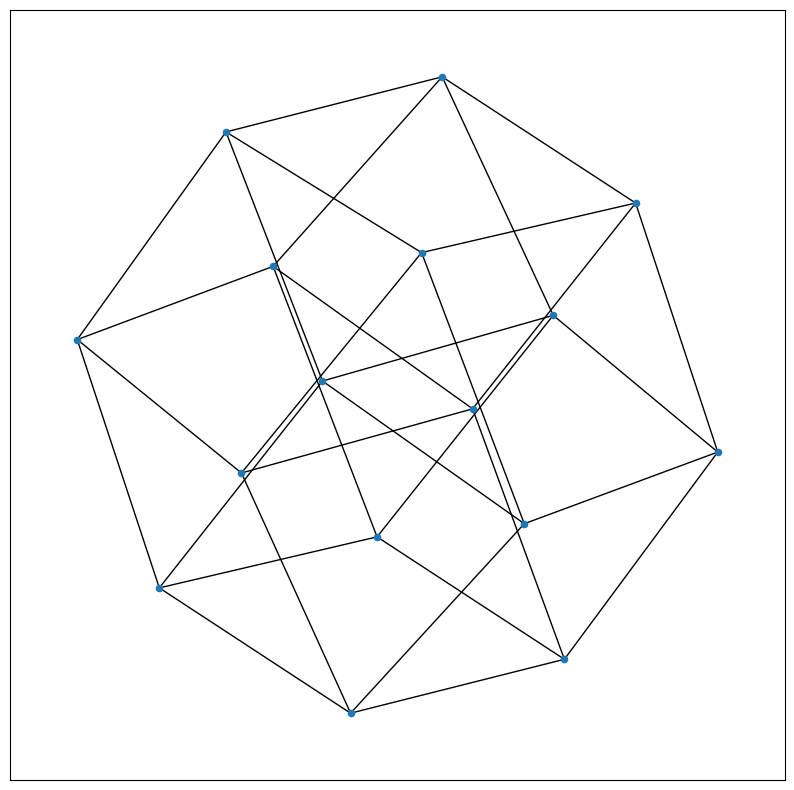

Node 1-1-1: {'workers': {139973858156112: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417de50>, 139973858153856: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417d580>, 139973858155008: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417da00>, 139973858152752: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417d130>}}
Node 2-1-1: {'workers': {139973858155440: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417dbb0>, 139973858152704: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417d100>, 139973858152896: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417d1c0>, 139973858598288: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e341e9d90>}}
Node 3-1-1: {'workers': {139973858598816: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e341e9fa0>, 139973858152848: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e3417d190>, 139973858595264: <ddls.devices.processors.gpus.A100.A100 object at 0x7f4e341e91c0>,

In [13]:
%autoreload
from ddls.environments.ramp_cluster.ramp_cluster_environment import RampClusterEnvironment

env = RampClusterEnvironment(topology_config=topology_config,
                             node_config=node_config,
                             path_to_save='/scratch/datasets/ddls/sims',
                             save_freq=100,
                             use_sqlite_database=True)
print(env)
env.topology.render()

for node in env.topology.graph:
    print(f'Node {node}: {env.topology.graph.nodes[node]}')

In [14]:
%autoreload
from ddls.managers.placers.random_job_placer import RandomJobPlacer
from ddls.managers.schedulers.srpt_job_scheduler import SRPTJobScheduler

control_plane = {
    'job_placer': RandomJobPlacer(),
    'job_scheduler': SRPTJobScheduler()
}

In [17]:
%autoreload
from ddls.distributions.uniform import Uniform
from ddls.utils import seed_stochastic_modules_globally

import time
import pprint


# seeds = [0, 1, 2]
seeds = [0]
verbose = True

for seed in seeds:
    print(f'\n\n\n~~~~~~~~~~~~~~~~~~~~~~~ Seed {seed} ~~~~~~~~~~~~~~~~~~~~~~~')
    seed_stochastic_modules_globally(seed)
    obs = env.reset(jobs_config=jobs_config,
                    max_simulation_run_time=float('inf'),
                    job_queue_capacity=10,
                    seed=seed,
                    verbose=True)
    
    start_time = time.time()
    while not done:
        # make decisions
        actions = {}
        actions['job_placement'] = control_plane['job_placer'].get_placement(cluster=env)
        actions['job_schedule'] = control_plane['job_scheduler'].get_schedule(new_placements=actions['job_placement'], cluster=env)

        # pass actions to cluster environment and step the cluster
        obs, action_set, reward, done, info = env.step(actions, verbose=verbose)
        if not verbose:
            print(f'Step {env.step_counter} | Jobs arrived: {env.num_jobs_arrived} | completed: {len(env.jobs_completed)} | blocked: {len(env.jobs_blocked)} | running: {len(env.jobs_running)} | queued: {len(env.job_queue)}')
    
    print(f'\nCompleted simulation in {time.time() - start_time:.3f} s')




~~~~~~~~~~~~~~~~~~~~~~~ Seed 0 ~~~~~~~~~~~~~~~~~~~~~~~
Initialised folder /scratch/datasets/ddls/sims/ramp_cluster/ramp_cluster_0/reset_2
Reset cluster environment.
Max sim run time: inf
